In [1]:
import numpy as np
import pandas as pd
import FinanceDataReader as fdr
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
%matplotlib inline

In [2]:
df_goodan = pd.read_csv('data_goodan_preprocessing.csv', index_col = 0)
df_goodan.index = pd.to_datetime(df_goodan.index)

df_etf = pd.read_csv('etf_top_99.csv', index_col = 0)
df_etf.index = pd.to_datetime(df_etf.index)

df_etf = df_etf.iloc[ : , : ]
df_etf = df_etf[['TIGER 레버리지(A123320)', 'KODEX 은선물(H)(A144600)', 'TIGER 소프트웨어(A157490)', 'KODEX 중국본토 A50(A169950)', 'TIGER 반도체(A091230)','KODEX 국고채3년(A114260)']]

asset_number = len(df_etf.columns) + 1

In [3]:
def goodan_selection(goodan) :
    
    df_data = df_etf.copy()
    df_data[goodan] = df_goodan[goodan]
    df_result = df_data.sort_values('Date')
    
    return df_result

In [4]:
def daily_to_month(start, end, df_daily):
    
    s = pd.date_range(start, end, freq = 'MS')
    e = pd.date_range(start, end, freq = 'M')

    v = []

    for i, j in zip(s, e) :
        
        date = pd.date_range(i, j)
        
        df_date_range_value = df_daily.loc[date].dropna()
        
        value_result = df_date_range_value.iloc[[0]]
        
        v.append(value_result)

    df_month = pd.concat(v)
    
    return df_month

In [5]:
def price_to_return_rate(data) :
    
    df_2 = data
    
    df_return = (np.log(data) - np.log(data.shift(1))).dropna()
    
    data = df_return.iloc[:,:]
    
    return data

In [6]:
def goodan_optimizer(value, asset_number, data, ratio, risk_tolerance) :
    
    expected_return = np.array(data.mean()*252)
    covariance_martix = data.cov()*252

    def objective(weights):
        return 0.5*np.sqrt(np.dot(weights.T, np.dot(covariance_martix, weights))) + 0.001*np.array([weights[i]**2 for i in range(len(weights))]).sum()

    def constraint1(weights):
        return sum(weights)-1

    def constraint2(weights):
        return weights[-1] - ratio

    w0 = np.array([(1/asset_number) for i in range(asset_number)])
    bounds = [[0,1] for i in range(asset_number)]
    constraints = [{'type':'eq','fun':constraint1}, {'type':'eq','fun':constraint2}]

    solution = minimize(objective,w0,method='SLSQP', bounds = bounds, constraints = constraints)
    return_gmv = (expected_return*solution.x).sum()
    
    def investment_tendency(weights) :
        return 0.5*np.sqrt(np.dot(weights.T, np.dot(covariance_martix, weights))) + 0.001*np.array([weights[i]**2 for i in range(len(weights))]).sum()

    basic_var = np.array([(1/asset_number) for i in range(asset_number)])
    bnds = [[0,1] for i in range(asset_number)]

    ef_return = [return_gmv, return_gmv+0.01, return_gmv+0.02]
    investment_tendency_rank = ['Risk aversion', 'Risk neutrality', 'Risk preference']

    if risk_tolerance == investment_tendency_rank[0] :
        r = ef_return[0]

    elif risk_tolerance == investment_tendency_rank[1] :
        r = ef_return[1]

    elif risk_tolerance == investment_tendency_rank[2] :
        r = ef_return[2]

    con1 = {'type':'eq','fun': lambda x : np.sum(x) - 1}
    con2 = {'type':'eq','fun': lambda x : (expected_return*x).sum() - r}
    con3 = {'type':'eq','fun': lambda x : x[-1] - ratio}
    cons = [con1,con2,con3]
    solution_risk_tolerance = minimize(investment_tendency, basic_var, method = 'SLSQP', bounds = bnds, constraints = cons)
    
    solution_risk_tolerance.x.round(3)
    
    return value * solution_risk_tolerance.x.round(3), solution_risk_tolerance.x.round(3)

In [7]:
def modeling(goodan, ratio, start, end, risk_tolerance):
    
    init = 1000000
    
    data_goodan = goodan_selection(goodan)
    
    df_month = daily_to_month(start, end, data_goodan)
    data = price_to_return_rate(df_month)
    
    # we will use 2 years' data as initial covariance matrix of markowitz model
    df_return = data.iloc[23: , : ]
    
    data = data.iloc[ : , : ]
    df_result = df_month.iloc[24: , : ]
    
    goodan_init = goodan_optimizer(init, asset_number, data.iloc[:23, :], ratio, risk_tolerance)[0]
    
    result = []
    weights = []
    
    for i in range(len(df_return)) :

        if i == 0 :

            asset_divided = []
            for j in range(asset_number) :

                value = goodan_init[j] * (1 + df_return.iloc[i,j])
                asset_divided.append(value) 

            asset_sum = 0
            for k in asset_divided :
                asset_sum = asset_sum + k

            result.append(asset_sum)
            weights.append(goodan_optimizer(init, asset_number, data.iloc[:23, :], ratio, risk_tolerance)[1])

        else :

            asset_divided = []
            for j in range(asset_number) :

                value = goodan_optimizer(asset_sum, asset_number, data.iloc[:23+i,:], ratio, risk_tolerance)[0][j] * (1 + df_return.iloc[i, j])
                asset_divided.append(value)

            asset_sum = 0
            for k in asset_divided :
                asset_sum = asset_sum + k

            result.append(asset_sum)
            weights.append(goodan_optimizer(asset_sum, asset_number, data.iloc[:23+i,:], ratio, risk_tolerance)[1])
            
    df_result['Portfolio'] = result
    
    df_weights = pd.DataFrame(weights)
    df_weights.columns = df_result.columns[:-1]
    df_weights.index = df_result.index
    df_weights = df_weights[df_weights.sum()[df_weights.sum() != 0].index]
    
    return df_result, df_weights

In [8]:
def result_plotting(result) :
    
    goodan = result[0].columns[-2]
    
    graph_portfolio = result[0]['Portfolio'] / result[0]['Portfolio'].iloc[0]
    graph_goodan = result[0].iloc[:, -2:-1] / result[0].iloc[:, -2:-1].iloc[0]
    
    plt.figure(figsize=(18,14))
    plt.style.use('seaborn')
    
    mpl.rc('font', family='nanumgothic')
    mpl.rc('axes', unicode_minus=False)
    
    ax1 = plt.subplot(2,1,1)
    plt.title('Portfolio Simulation', fontsize = 20)
    plt.xlabel('Time', fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.plot(graph_portfolio, c = 'deepskyblue', label = 'Portfolio')
    plt.plot(graph_goodan, c = 'magenta', label = goodan)
    plt.legend(loc=0, fontsize = 15)

    ax2 = plt.subplot(2,1,2)
    plt.title('Asset weights', fontsize = 20)
    plt.xlabel('Time', fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

    for i in range(len(result[1].columns)) :
        plt.plot(result[1].iloc[:,i], label = result[1].columns[i])

    plt.legend(loc=0, fontsize = 10)
    
    return plt.show()

In [9]:
def backtest(df) :
    
    def backtest_index(df):

        Holding_period_return = round(df.pct_change().add(1).cumprod()[-1]-1,4)

        CAGR = round((1 + (df.iloc[-1] - df.iloc[0])/df.iloc[0])**(1/(round(len(df) / 12, 0))) - 1, 4)

        df_return = df.pct_change().dropna()
        Volatility = round((df_return.var()*252)**0.5, 4)

        Sharpe_ratio = round((Holding_period_return - 0.015) / Volatility, 4)

        r = df.pct_change().add(1).cumprod()
        dd = r.div(r.cummax()).sub(1)
        Maximum_draw_down = round(dd.min()*(-1),4)

        mean = np.mean(df.pct_change())
        std_dev = np.std(df.pct_change())

        VaR_95 = norm.ppf(1-0.95, mean, std_dev)
        VaR_99 = norm.ppf(1-0.99, mean, std_dev)

        Value_at_Risk_95 = round(1000000 * VaR_95 * np.sqrt(20), 0)
        Value_at_Risk_99 = round(1000000 * VaR_99 * np.sqrt(20), 0)
        
        backtest = [Holding_period_return, CAGR, Volatility, Sharpe_ratio, Maximum_draw_down, Value_at_Risk_95, Value_at_Risk_99]
        
        return backtest
    
    index = ['Holding_period_return', 'CAGR', 'Volatility', 'Sharpe_ratio', 'Maximum_draw_down', 'Value_at_Risk_95', 'Value_at_Risk_99']
    
    df_portfolio = df[0].iloc[ : , -1]
    df_goodan = df[0].iloc[ : , -2]
    goodan_name = df_goodan.name
    
    back_test_results = pd.DataFrame(index = index)
    back_test_results['Portfolio'] = backtest_index(df_portfolio)
    back_test_results[goodan_name] = backtest_index(df_goodan)
    
    return back_test_results.T

risk tolerance : ['Risk aversion', 'Risk neutrality', 'Risk preference']

goodan : ['Ajax', 'Juventus', 'Celtic,PLC', 'Roma,asr', 'Besiktas', 'Fenerbahce', 'Borussia dotmund', 'Manchester United', 'Lazio,ssl'],

In [10]:
result = modeling('Celtic,PLC', 0.21, '2014-01-01', '2019-10-31', 'Risk preference')

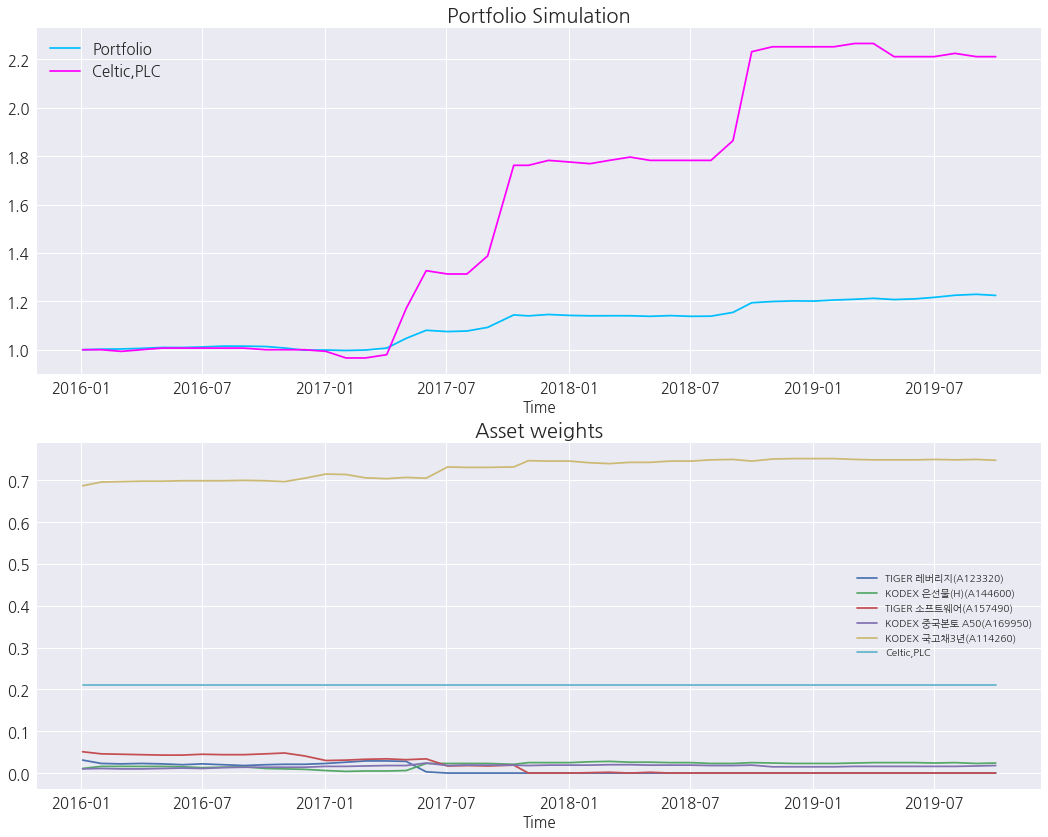

In [11]:
result_plotting(result)

In [12]:
backtest(result)

,Holding_period_return,CAGR,Volatility,Sharpe_ratio,Maximum_draw_down,Value_at_Risk_95,Value_at_Risk_99
Portfolio,0.2244,0.0519,0.1850,1.1319,0.0179,-64301.0,-99415.0
"Celtic,PLC",1.2109,0.2194,0.9517,1.2566,0.0405,-349568.0,-530234.0


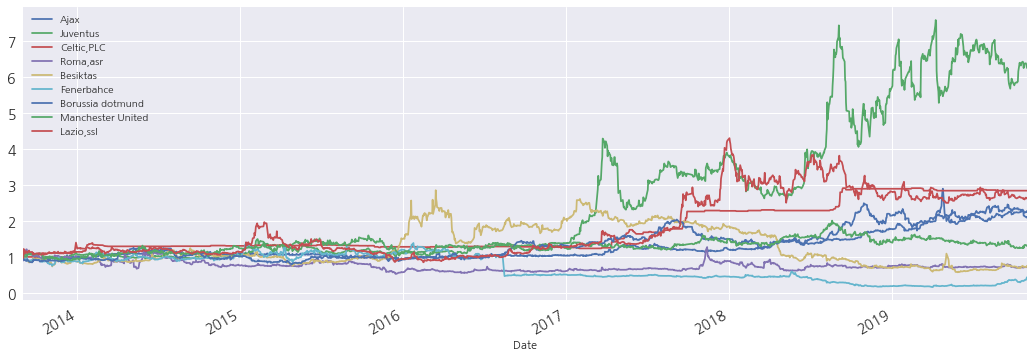

In [13]:
(df_goodan/df_goodan.iloc[0]).plot(figsize = (18,6), fontsize = 14)